<a href="https://colab.research.google.com/github/Jitendra7073/Indian-Plants-Classification-Using-a-Custom-CNN-Model/blob/main/Augmentation_of_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# STEP 2: Resize All Images to 252x252.

In [ ]:
import os
from PIL import Image
import pillow_heif  # For HEIC support

# Define paths
input_folder = "/content/drive/MyDrive/DL_00/0_1"  # Source folder
output_folder = "/content/0_1_resized"  # Output folder

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Resize all images
for filename in os.listdir(input_folder):
    img_path = os.path.join(input_folder, filename)

    try:
        # Convert HEIC to JPEG
        if filename.lower().endswith(".heic"):
            heif_image = pillow_heif.open_heif(img_path)
            img = Image.frombytes(
                heif_image.mode,
                heif_image.size,
                heif_image.data
            )
            filename = filename.replace(".heic", ".jpg")  # Change extension to .jpg
            save_format = "JPEG"
        elif filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img = Image.open(img_path)
            save_format = img.format  # Keep original format
        else:
            continue  # Skip non-image files

        # Resize image
        img_resized = img.resize((252, 252))

        # Save resized image
        output_path = os.path.join(output_folder, filename)
        img_resized.save(output_path, format=save_format)  # Ensure correct format

    except Exception as e:
        print(f"Error processing {filename}: {e}")

print("✅ All images resized to 252x252!")


✅ All images resized to 252x252!


# STEP 3: perform the Data Augmentation

---



In [ ]:
import os
import cv2
import numpy as np
from albumentations import (
    HorizontalFlip, VerticalFlip, RandomBrightnessContrast, Rotate, GaussianBlur, Compose, Resize
)

# Define paths
input_folder = "/content/0_1_resized"
output_folder = "/content/0_3_selected_augmentation_updated"
os.makedirs(output_folder, exist_ok=True)

# Augmentation pipeline
augmentations = Compose([
    Resize(252, 252),  # Ensure all images are 252x252
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    GaussianBlur(blur_limit=3, p=0.3),
])

# Augment images
count = 0
for filename in os.listdir(input_folder):
    if filename.endswith((".jpg", ".jpeg", ".png", ".HEIC")):
        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Generate 5 augmented versions of each image
        for i in range(6):  # Change 5 to a higher number for more variations
            augmented = augmentations(image=image)['image']
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{i}.jpg")
            cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
            count += 1

print(f"Generated {count} augmented images.")
print("All Done ✅✅")

Generated 1668 augmented images.
All Done ✅✅


Rename the all Images Names with the indexing number from 1 to n ( for better counting)

In [ ]:
import os
import shutil

def rename_and_move_files(input_folder, output_folder):
    # Ensure the destination folder exists
    os.makedirs(output_folder, exist_ok=True)

    # List and sort all files in the source directory
    files = sorted(os.listdir(input_folder))

    # Filter only files (excluding directories)
    files = [f for f in files if os.path.isfile(os.path.join(input_folder, f))]

    # Rename and move files
    for index, filename in enumerate(files, start=1):
        file_extension = os.path.splitext(filename)[1]  # Get file extension
        new_filename = f"{index}{file_extension}"  # Create new filename

        source_path = os.path.join(input_folder, filename)
        destination_path = os.path.join(output_folder, new_filename)

        shutil.copy2(source_path, destination_path)  # Copy with metadata

    print(f"Files renamed and moved successfully.")

# Example usage
input_folder = "/content/0_3_selected_augmentation_updated"  # Change to your source folder
output_folder = "/content/drive/MyDrive/DL_00/datasets/SOI"  # Change to your destination folder

rename_and_move_files(input_folder, output_folder)


Files renamed and moved successfully.


Move Images from one folder to another folder

In [ ]:
import os
import shutil

def move_images(input_folder, output_folder):
    # Ensure the destination folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Define common image file extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.webp', '.HEIC')

    # List all files in the source directory
    files = os.listdir(input_folder)

    # Move only image files
    for file in files:
        if file.lower().endswith(image_extensions):
            source_path = os.path.join(input_folder, file)
            destination_path = os.path.join(output_folder, file)
            shutil.move(source_path, destination_path)  # Move file


    print(f"All images moved successfully.")

# Example usage
input_folder = "/content/0_3_resized"  # Change this to your source folder
output_folder = "/content/drive/MyDrive/DL_00/0_0_2"  # Change this to your destination folder

move_images(input_folder, output_folder)


All images moved successfully.


# STEP 4: Image Normalization Script (PNG, JPEG, JPG, HEIC)
Normalization scales pixel values, improving training stability and convergence.

In [ ]:
import cv2
import numpy as np
import os
import glob
from PIL import Image
import pillow_heif  # For HEIC format support

# Function to normalize images
def normalize_image(img_path, target_size=(252, 252)):
    """
    Reads an image, resizes it, and normalizes pixel values to the range [0,1].

    Args:
        img_path (str): Path to the image.
        target_size (tuple): Desired image size (width, height).

    Returns:
        np.array: Normalized image array.
    """

    # Check if file is HEIC format
    if img_path.lower().endswith('.heic'):
        heif_file = pillow_heif.open_heif(img_path)  # Load HEIC image
        img = Image.frombytes(
            heif_file.mode, heif_file.size, heif_file.data[0]
        )  # Convert HEIC to PIL Image
        img = np.array(img)  # Convert to NumPy array
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert PIL Image to OpenCV BGR
    else:
        # Read image using OpenCV (faster)
        img = cv2.imread(img_path)

        # Convert BGR (OpenCV default) to RGB (standard format)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image to target size (252x252) with INTER_AREA (better for downscaling)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # Normalize pixel values from [0,255] → [0,1]
    img = img.astype(np.float32) / 255.0

    return img


# Function to process all images in a directory
def process_images(input_folder, output_folder):
    """
    Processes all images in the input folder, normalizes them, and saves the results.

    Args:
        input_folder (str): Folder containing raw images.
        output_folder (str): Folder to save normalized images.
    """

    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get all image files (JPEG, JPG, PNG, HEIC) - Case insensitive
    image_files = []
    for ext in ["*.png", "*.jpg", "*.jpeg", "*.heic"]:
        image_files.extend(glob.glob(os.path.join(input_folder, ext)))

    # Process each image
    for img_path in image_files:
        try:
            # Normalize the image
            normalized_img = normalize_image(img_path)

            # Convert back to 8-bit (0-255) for saving
            normalized_img_255 = (normalized_img * 255).astype(np.uint8)

            # Get filename and save the processed image
            filename = os.path.basename(img_path)
            save_path = os.path.join(output_folder, filename)

            cv2.imwrite(save_path, cv2.cvtColor(normalized_img_255, cv2.COLOR_RGB2BGR))  # Save in OpenCV format

            print(f"✅ Processed: {filename}")
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")


# Example Usage
input_folder = "/content/drive/MyDrive/DL_00/datasets/SOI"  # Folder containing original images
output_folder = "/content/drive/MyDrive/DL_00/datasets/SongOfIndia"  # Folder to save normalized images

process_images(input_folder, output_folder)


✅ Processed: 1.jpg
✅ Processed: 2.jpg
✅ Processed: 3.jpg
✅ Processed: 4.jpg
✅ Processed: 5.jpg
✅ Processed: 6.jpg
✅ Processed: 7.jpg
✅ Processed: 8.jpg
✅ Processed: 9.jpg
✅ Processed: 10.jpg
✅ Processed: 11.jpg
✅ Processed: 12.jpg
✅ Processed: 13.jpg
✅ Processed: 14.jpg
✅ Processed: 15.jpg
✅ Processed: 16.jpg
✅ Processed: 17.jpg
✅ Processed: 18.jpg
✅ Processed: 19.jpg
✅ Processed: 20.jpg
✅ Processed: 21.jpg
✅ Processed: 22.jpg
✅ Processed: 23.jpg
✅ Processed: 24.jpg
✅ Processed: 25.jpg
✅ Processed: 26.jpg
✅ Processed: 27.jpg
✅ Processed: 28.jpg
✅ Processed: 29.jpg
✅ Processed: 30.jpg
✅ Processed: 31.jpg
✅ Processed: 32.jpg
✅ Processed: 33.jpg
✅ Processed: 34.jpg
✅ Processed: 35.jpg
✅ Processed: 36.jpg
✅ Processed: 37.jpg
✅ Processed: 38.jpg
✅ Processed: 39.jpg
✅ Processed: 40.jpg
✅ Processed: 41.jpg
✅ Processed: 42.jpg
✅ Processed: 43.jpg
✅ Processed: 44.jpg
✅ Processed: 45.jpg
✅ Processed: 46.jpg
✅ Processed: 47.jpg
✅ Processed: 48.jpg
✅ Processed: 49.jpg
✅ Processed: 50.jpg
✅ Process

Found 3459 files belonging to 3 classes.
Using 2768 files for training.
Found 3459 files belonging to 3 classes.
Using 691 files for validation.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 250, 250, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 125, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 123, 123, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      13,779,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,872,707 (52.92 MB)

 Trainable params: 13,872,707 (52.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.5592 - loss: 90.6746 - val_accuracy: 0.8205 - val_loss: 0.4459
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.8531 - loss: 0.4285 - val_accuracy: 0.9247 - val_loss: 0.2066
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9340 - loss: 0.2039 - val_accuracy: 0.9103 - val_loss: 0.2492
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.9561 - loss: 0.1303 - val_accuracy: 0.9190 - val_loss: 0.2317
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9702 - loss: 0.1022 - val_accuracy: 0.9508 - val_loss: 0.1174
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9536 - loss: 0.1561 - val_accuracy: 0.9465 - val_loss: 0.1940
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9490 - loss: 0.1853 - val_accuracy: 0.8842 - val_loss: 0.3661
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9597 - loss: 0.1582 - val_acc

Test Accuracy: 0.94


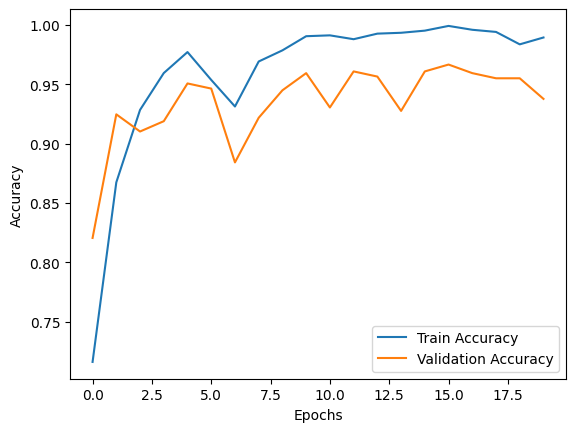

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# Define Paths & Parameters
data_dir = "/content/drive/MyDrive/DL_00/datasets/"  # Path to dataset
img_size = (252, 252)  # Ensure consistency in image size
batch_size = 32  # Batch size
num_classes = 3  # Number of plant categories

# Load dataset and split (80% Train, 20% Validation)
train_dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Build CNN Model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(252, 252, 3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Print model architecture

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

# Evaluate Model on Test Data
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the trained model
model.save("plant_identifier.h5")

# Plot Accuracy & Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Ploting the Accuracy and Loss Graph

Found 3459 files belonging to 3 classes.
Using 2768 files for training.
Found 3459 files belonging to 3 classes.
Using 691 files for validation.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 199ms/step - accuracy: 0.5332 - loss: 113.4488 - val_accuracy: 0.7771 - val_loss: 0.5496
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.7766 - loss: 0.5805 - val_accuracy: 0.8177 - val_loss: 0.4814
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.8644 - loss: 0.4185 - val_accuracy: 0.8596 - val_loss: 0.3707
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.9055 - loss: 0.3018 - val_accuracy: 0.8379 - val_loss: 0.7424
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.7669 - loss: 0.6960 - val_accuracy: 0.6961 - val_loss: 0.8016
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.7168 - loss: 0.9261 - val_accuracy: 0.8755 - val_loss: 0.4026
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.8510 - loss: 0.4103 - val_accuracy: 0.8162 - val_loss: 0.5271
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.8864 - loss: 0.3576 - val_ac

Test Accuracy: 0.93
Test Loss: 0.23


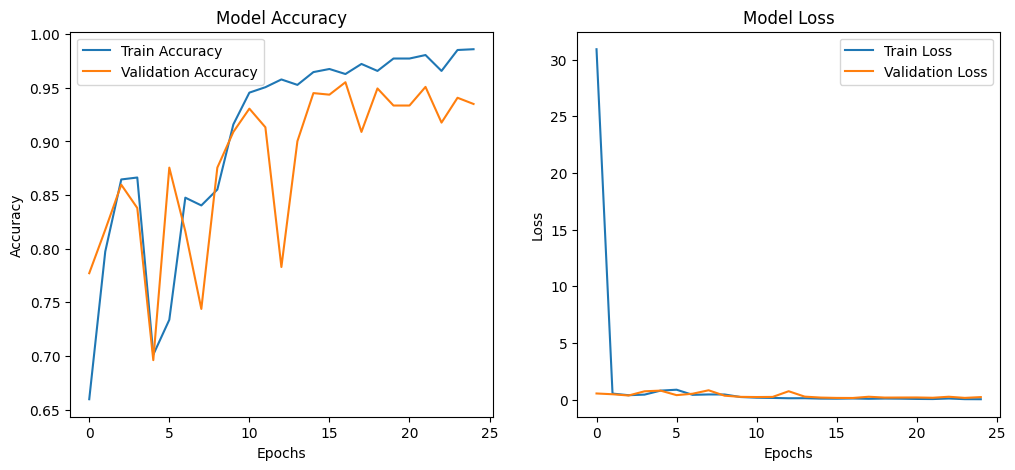

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

# Define Paths & Parameters
data_dir = "/content/drive/MyDrive/D_L/DL_00/datasets/"  # Path to dataset
img_size = (224, 224)  # Ensure consistency in image size
batch_size = 32  # Batch size => hyperprameters
num_classes = 3  # Number of plant categories

# Load dataset and split (80% Train, 20% Validation)
train_dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Build CNN Model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()  # Print model architecture

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25
)

# Evaluate Model on Test Data
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Save the trained model
model.save("plant_identifier.h5")

# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()
